# Resnet 152

In [1]:
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras

# 랜덤시드 고정시키기
np.random.seed(3)

imgSize = 400
batch=8

In [2]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()



['/device:GPU:0', '/device:GPU:1']

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


eye_folder = "/data1/train_data/kwuniv/skin/3rd/erythema/split"

# 데이터셋 불러오기
# validation_split=0.25 을 하면 training 과 validation의 subset이 자동으로 구성됨

train_datagen = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    zoom_range=0.2,
    channel_shift_range=0.1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255, 
)

train_generator = train_datagen.flow_from_directory(
        eye_folder + "/train",
        target_size=(imgSize, imgSize),
        batch_size=batch,
        interpolation = 'box',
        shuffle = True,
)

test_datagen = ImageDataGenerator(
    rescale=1./255, 
)

test_generator = test_datagen.flow_from_directory(
        eye_folder + "/val",
        target_size=(imgSize, imgSize),
        batch_size=batch,
        shuffle = False,
)

print(len(test_generator.class_indices))


Found 349 images belonging to 4 classes.
Found 88 images belonging to 4 classes.
4


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet152V2

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

# 모델 구성하기

https://keras.io/ko/applications/#resnet

```
keras.applications.resnet.ResNet152(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000
)
```

광운대 생성 param
```
ResNet152V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3),
           pooling='avg', backend=keras.backend, layers=keras.layers, models=keras.models,
           utils=keras.utils)
```

Adma
```
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam', **kwargs
)
```

In [5]:
# 위에 설정
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
# , "GPU:0" v100 좋은거
# , "GPU:1" 1080 덜 좋은거

model = Sequential()

model.add(ResNet152V2(weights="imagenet", include_top=False, pooling='avg', input_shape=(imgSize, imgSize, 3), classes=len(test_generator.class_indices) ))

# model.add(Dense(2048, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
model.add(Dense(len(test_generator.class_indices), activation='softmax'))

model.summary()

# learning_rate 기본 0.001
# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# opt = tf.keras.optimizers.SGD(learning_rate = 0.003, decay = 1e-5, momentum = 0.9, nesterov = True)
opt = tf.keras.optimizers.SGD(learning_rate = 0.001, decay = 1e-5, momentum = 0.999, nesterov = True)

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=.1)

# 모델 컴파일
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 58,339,844
Trainable params: 58,196,100
Non-trainable params: 143,744
_________________________________________________________________


In [6]:
# # model = tf.keras.models.load_model('/data2/2.ai/eyes/resnet152/model/20200722_115300_resnet152v2_400_False_SGD_400_jh/model-015-0.996578-0.834734.h5',custom_objects={'SeqSelfAttention':SeqSelfAttention})

modelname = model.layers[0].name
# opt = model.optimizer


In [7]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from datetime import datetime
import json

# today = datetime.now().strftime("%Y%m%d_%H%M%S") + "_" + type(opt).__name__ + "_" + "pftest"
today = datetime.now().strftime("%Y%m%d_%H%M%S")
today = today + "_" + modelname
today = today + "_" + str(imgSize)
today = today + "_" + str(model.layers[0].weights == None)
today = today + "_" + type(opt).__name__
today = today + "_skin"

tb_hist = TensorBoard(log_dir='./graph/' + today, histogram_freq=1)

os.mkdir('./model/' + today)
check_point = ModelCheckpoint('./model/' + today + '/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1,
                                      monitor='val_accuracy', save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')


train_augs_file = open('./model/' + today + "/augs.txt", "w")
n = train_augs_file.write(json.dumps(train_datagen.__dict__, indent=4, sort_keys=True))
train_augs_file.close()

# class_weight = {0:0.14, 1:0.89, 2:0.97}

20200606_232548 : kw eye dataset, weight 사용 안함
20200607_123851_SGD : 이미지에 점찍어서 분류해보기

In [14]:
# 모델 학습시키기
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=test_generator,
    workers=8,
    callbacks=[tb_hist, check_point], #, earlystop
#     class_weight=class_weight
)

Epoch 1/60
44/44 [==============================] - ETA: 0s - loss: 0.7876 - accuracy: 0.7393
Epoch 00001: val_accuracy improved from 0.82955 to 0.84091, saving model to ./model/20200804_170450_resnet152v2_400_False_SGD_skin/model-001-0.739255-0.840909.h5
44/44 [==============================] - 18s 417ms/step - loss: 0.7876 - accuracy: 0.7393 - val_loss: 0.6915 - val_accuracy: 0.8409
Epoch 2/60
44/44 [==============================] - ETA: 0s - loss: 0.8117 - accuracy: 0.7335
Epoch 00002: val_accuracy did not improve from 0.84091
44/44 [==============================] - 16s 357ms/step - loss: 0.8117 - accuracy: 0.7335 - val_loss: 0.7125 - val_accuracy: 0.8068
Epoch 3/60
44/44 [==============================] - ETA: 0s - loss: 0.7526 - accuracy: 0.7564
Epoch 00003: val_accuracy did not improve from 0.84091
44/44 [==============================] - 16s 361ms/step - loss: 0.7526 - accuracy: 0.7564 - val_loss: 0.7525 - val_accuracy: 0.7841
Epoch 4/60
44/44 [==============================] 

KeyboardInterrupt: 

In [ ]:
# 모델 평가하기
print("-- Evaluate --")

scores = model.evaluate_generator(
            test_generator, 
            workers=38,
)

print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))


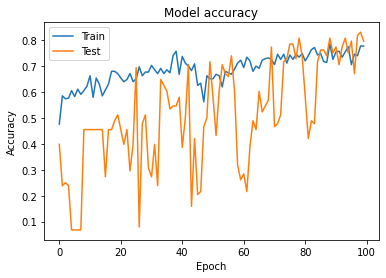

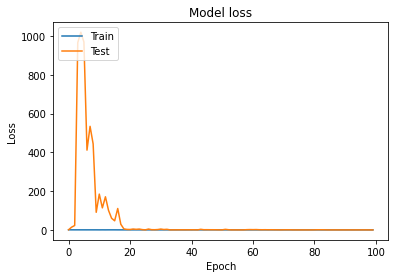

In [10]:
import matplotlib.pyplot as plt

# 학습 정확성 값과 검증 정확성 값을 플롯팅 합니다. 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 학습 손실 값과 검증 손실 값을 플롯팅 합니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
predicts = model.predict_classes(test_generator)

# for p in predicts:
#     print(p)

print("-"*100)
print(predicts)
print("-"*100)
print(test_generator.labels)
results = {}

for i, lb in enumerate(test_generator.labels):
    l = str(lb) + "-" + str(predicts[i])
    if l in results:
        results[l] = results[l] + 1
    else:
        results[l] = 1;

print(sorted(results.items(), key=lambda x: x[0], reverse = False))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 2 3 1 1 2 2 1 1 2 2 1 1 2
 1 1 2 2 2 2 2 2 3 3 3 1 3 3]
----------------------------------------------------------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
{'0-0': 19, '0-1': 2, '1-1': 34, '1-0': 6, '2-2': 12, '2-3': 1, '2-1': 8, '3-3': 5, '3-1': 1}
[('0-0', 1